In [31]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from basepair.imports import *
from basepair.extractors import bw_extract
from basepair.datasets import StrandedProfile
from basepair.preproc import AppendCounts
from basepair.config import valid_chr, test_chr
from basepair.plot.evaluate import regression_eval
from basepair.plot.utils import plt9_tilt_xlab
from basepair.cli.evaluate import eval_profile
from basepair.exp.paper.config import *
from basepair.data import Dataset
import matplotlib.ticker as ticker
import tree
from kipoi.data_utils import (numpy_collate, numpy_collate_concat, get_dataset_item,
                              DataloaderIterable, batch_gen, get_dataset_lens, iterable_cycle)
import warnings
warnings.filterwarnings("ignore")

paper_config() # Use matplotlib paper config

In [2]:
# Main metrics
from gin_train.metrics import auprc, auc
from sklearn.metrics import precision_recall_curve
from concise.eval_metrics import auprc, auc


class RecallAtFDR:
    def __init__(self, fdr):
        self._fdr = fdr
        
    def __call__(self, y_true, y_pred):
        precision, recall, _ = precision_recall_curve(y_true[y_true != -1],
                                                      y_pred[y_true != -1])
        precision_threshold = 1 - self._fdr
        # recall[np.searchsorted(precision - precision_threshold, 0)]
        return recall[precision >= precision_threshold].max()

metrics = {'auPRC': auprc,
           'Recall @ 10% FDR': RecallAtFDR(0.1),
           'Recall @ 20% FDR': RecallAtFDR(0.2),
           'Recall @ 50% FDR': RecallAtFDR(0.5),
           'auROC': auc
          }

In [3]:
experiments = {
    'nexus/binary': 'nexus,gw,OSNK,1,0,0,FALSE,same,0.5,64,25,0.001,9,FALSE',
    'nexus/binary+profile': 'nexus,gw,OSNK,1,0.1,0.01,FALSE,same,0.5,64,25,0.001,9,FALSE',
    'nexus/binary+profile-bias-corrected': 'nexus,gw,OSNK,1,0.1,0.01,FALSE,same,0.5,64,25,0.001,9,FALSE,[1,50],TRUE,None',
}

In [4]:
from basepair.config import get_data_dir, get_repo_root
rdir = get_repo_root()

# Parameters
dataspec_file = rdir / "src/bpnet-pipeline/ChIP-nexus.dataspec.yml"
fdir = Path(f'{ddir}/figures/method-comparison/modisco')
seq_width = 1000
num_workers = 10

In [5]:
from basepair.datasets import get_gw_StrandedProfile_datasets

In [21]:
intervals_file = ('/oak/stanford/groups/akundaje/avsec/basepair/data/processed/'
                  'comparison/data/chip-nexus/OSNK.50-percent-overlap.tsv.gz')
# Alternatively: OSN -> start.

data = get_gw_StrandedProfile_datasets(
    valid_chr=['chr2', 'chr3', 'chr4'],
    test_chr=['chr1', 'chr8', 'chr9'],
    intervals_file=intervals_file,
    peak_width=1000,
    include_metadata=True,
    include_classes=True,
    tasks=['Oct4', 'Sox2', 'Nanog', 'Klf4'],
    exclude_chr=['chrX', 'chrY'],
    taskname_first=True,
    profile_bias_pool_size=None,  # TODO(avsec)?
    dataspec='../bpnet-pipeline/ChIP-nexus.dataspec.yml',
    seq_width=1000,
    only_classes=False,
    )

Skipped 13 intervals outside of the genome size
Skipped 3 intervals outside of the genome size
Skipped 3 intervals outside of the genome size


In [22]:
valid = dict(data[1])['valid-genome-wide']

In [8]:
len(valid)

9973070

In [9]:
valid[0].keys()

dict_keys(['inputs', 'targets', 'metadata'])

### Evaluate experimental replicates

In [10]:
rep_indices = [f'N{x:02d}' for x in np.arange(1, 21)]
reps = pd.read_csv("https://docs.google.com/spreadsheets/d/1PvHGy0P9_Yq0tZFw807bjadxaZHAYECE4RytlI9rdeQ/export?gid=0&format=csv")
reps = reps[reps.Mnemonic.isin(rep_indices)]

In [11]:
def get_bigwig(row, strand):
    rep_n = int(row['Rep Number'])
    task = row['TF Name'].capitalize()
    rep_name = row['FTP Name'].split(".")[0]
    pipeline_dir = '/oak/stanford/groups/akundaje/avsec/software/chip-nexus-pipeline/cromwell-executions/chip_nexus'
    path = f"{pipeline_dir}/{task}/call-count_signal_track/shard-{rep_n -1}/execution/{rep_name}.trim.merged.nodup.{strand}.bigwig"
    if not os.path.exists(path):
        raise ValueError(f'Path {path} does not exist.')
    return path

def get_taskspec(rows):
    task = rows.iloc[0]['TF Name'].capitalize()
    pos_counts=[get_bigwig(rows.iloc[i], 'positive') for i in range(len(rows))]
    neg_counts=[get_bigwig(rows.iloc[i], 'negative') for i in range(len(rows))]
    return TaskSpec(task=task, pos_counts=pos_counts, neg_counts=neg_counts)

In [36]:
def dataspec_metarep1_fn():
    dataspec_metarep1 = DataSpec(task_specs={task: get_taskspec(reps[(reps['TF Name'].str.capitalize() == task) & (reps['Held-out test'] == False)])
                                                     for task in tasks},
                      fasta_file="")
    dataspec_metarep1.touch_all_files()
    return dataspec_metarep1

def dataspec_metarep2_fn():
    dataspec_metarep2 = DataSpec(task_specs={task: get_taskspec(reps[(reps['TF Name'].str.capitalize() == task) & (reps['Held-out test'] == True)])
                                                     for task in tasks},
                      fasta_file="")

    dataspec_metarep2.touch_all_files()
    return dataspec_metarep2

In [37]:
import pybedtools
from basepair.preproc import resize_interval


def range2intervals(range_dict, resize=None):
    r = range_dict
    intervals = []
    for i in range(len(r['start'])):
        interval = pybedtools.create_interval_from_list([r['chr'][i], int(r['start'][i]), int(r['end'][i])])
        if resize is not None:
            interval = resize_interval(interval, resize)
        intervals.append(interval)
    return intervals

In [41]:
# TODO - make sure pyBigWig is loaded on each thread separately - wrap the dataspec into a funtion
class ReplicateDataset(Dataset):
    def __init__(self, intervals, dataspec_metarep_fn, interval_width=200):
        self.intervals = intervals
        self._dataspec_metarep_fn = dataspec_metarep_fn
        self._dataspec_metarep = None

    def __len__(self):
        return len(self.intervals)

    def __getitem__(self, idx):
        if self._dataspec_metarep is None:
            self._dataspec_metarep = self._dataspec_metarep_fn()
        interval = self.intervals[idx]
        output = self._dataspec_metarep.load_counts([interval])
        return {'predicted/' + task: output[task].sum(axis=(1,2)) for task in output}

In [63]:
from kipoi.data import BatchDataset

# TODO - make sure pyBigWig is loaded on each thread separately - wrap the dataspec into a funtion
class ReplicateBatchDataset(BatchDataset):
    def __init__(self, intervals, dataspec_metarep_fn, batch_size=batch_size):
        self.intervals = intervals
        self.batch_size = batch_size
        self._dataspec_metarep_fn = dataspec_metarep_fn
        self._dataspec_metarep = None

    def __len__(self):
        return len(self.intervals) // self.batch_size + 1

    def __getitem__(self, idx):
        if self._dataspec_metarep is None:
            self._dataspec_metarep = self._dataspec_metarep_fn()
        sl = slice(idx * self.batch_size, (idx + 1) * self.batch_size)
        intervals = self.intervals[sl]
        output = self._dataspec_metarep.load_counts(intervals)
        return {'predicted/' + task: output[task].sum(axis=(1,2)) for task in output}

In [43]:
dataset_metarep1 = ReplicateDataset(valid_intervals, dataspec_metarep1_fn)

In [ ]:
dataset_metarep1 = ReplicateBatchDataset(valid_intervals, dataspec_metarep1_fn, batch_size=1024)
dataset_metarep1 = dataset_metarep1.load_all(batch_size=1, num_workers=10)

In [78]:
# TODO - write a script that will store the predictions into a file:

In [81]:
df_intervals = pd.read_csv(intervals_file, sep='\t')

In [86]:
def get_dataspec_metarep(task, test_heldout):
    dataspec_metarep1 = DataSpec(task_specs={task: get_taskspec(reps[(reps['TF Name'].str.capitalize() == task) & (reps['Held-out test'] == test_heldout)])},
                                 fasta_file="")
    dataspec_metarep1.touch_all_files()
    return dataspec_metarep1


def range2intervals(range_dict, resize=None):
    r = range_dict
    intervals = []
    for i in range(len(r['start'])):
        interval = pybedtools.create_interval_from_list([r['chr'][i], int(r['start'][i]), int(r['end'][i])])
        if resize is not None:
            interval = resize_interval(interval, resize)
        intervals.append(interval)
    return intervals

In [85]:
df_intervals.head()

,CHR,START,END,Oct4,Sox2,Nanog,Klf4
25277421,chr2,0,1000,0.0,0.0,0.0,0.0
25277422,chr2,50,1050,0.0,0.0,0.0,0.0
25277423,chr2,100,1100,0.0,0.0,0.0,0.0
25277424,chr2,150,1150,0.0,0.0,0.0,0.0
25277425,chr2,200,1200,0.0,0.0,0.0,0.0


In [83]:
valid_chr = ['chr2', 'chr3', 'chr4']
df_intervals = df_intervals[df_intervals.CHR.isin(valid_chr)]

In [88]:
task = 'Oct4'

In [87]:
dataspec_task = get_dataspec_metarep(task, True)

In [ ]:
batch_size = 1000


In [ ]:
for i in tqdm(range(len(df_intervals) // batch_size + 1)):
    sl = slice(i * batch_size, (i + 1) * batch_size)
    df_batch = df_intervals_subset.iloc[sl]
    df_batch

In [24]:
# Load all intervals and targets
valid_intervals = []
target_list = []
batch_size = 64
for batch in tqdm(valid.batch_iter(batch_size=batch_size, num_workers=8),
                  total=len(valid) // batch_size):
    valid_intervals += range2intervals(batch['metadata']['range'], resize=200)
    target_list.append(batch['targets'])

155830it [09:36, 270.44it/s]                            


In [ ]:
# TODO - can we try to load the whole data into memory?

In [ ]:
batch_size = 1000
dataspec_metarep1 = dataspec_metarep1_fn()
prediction_list_metarep1 = []
for i in tqdm(range(len(valid_intervals) // batch_size + 1)):
    sl = slice(i * batch_size, (i + 1) * batch_size)
    intervals = valid_intervals[sl]
    output = dataspec_metarep1.load_counts(intervals)
    predictions = {'predicted/' + task: output[task].sum(axis=(1,2)) for task in output}
    prediction_list_metarep1.append(predictions)

  0%|          | 3/9974 [00:08<7:48:54,  2.82s/it]

In [ ]:
batch_size = 1000
# dataspec_metarep2.touch_all_files()
dataspec_metarep2 = dataspec_metarep2_fn()
prediction_list_metarep2 = []
for i in tqdm(range(len(valid_intervals) // batch_size + 1)):
    sl = slice(i * batch_size, (i + 1) * batch_size)
    intervals = valid_intervals[sl]
    output = dataspec_metarep2.load_counts(intervals)
    predictions = {'predicted/' + task: output[task].sum(axis=(1,2)) for task in output}
    prediction_list_metarep2.append(predictions)

In [ ]:
# TODO - evaluate the performance & generate the plots

In [ ]:
targets = numpy_collate_concat(tree.map_structure(np.ravel, target_list))
predictions_metarep1 = numpy_collate_concat(tree.map_structure(np.ravel, prediction_list_metarep1))
predictions_metarep2 = numpy_collate_concat(tree.map_structure(np.ravel, prediction_list_metarep2))
df_metarep1 = pd.DataFrame({**predictions_metarep1, **targets})
df_metarep2 = pd.DataFrame({**predictions_metarep2, **targets})

In [ ]:
performance_metrics = []
for task in tasks:
    print(task)
    y_true = df_metarep1[f'{task}/class']
    y_pred = df_metarep1[f'predicted/{task}/class']
    for metric_name, metric in metrics.items():
        performance_metrics.append({'TF': task,
                                    'value': metric(y_true[y_true!= -1], y_pred[y_true!= -1]),
                                    'metric_name': metric_name,
                                    'exp_name': 'metarep1'})

for task in tasks:
    print(task)
    y_true = df_metarep2[f'{task}/class']
    y_pred = df_metarep2[f'predicted/{task}/class']
    for metric_name, metric in metrics.items():
        performance_metrics.append({'TF': task,
                                    'value': metric(y_true[y_true!= -1], y_pred[y_true!= -1]),
                                    'metric_name': metric_name,
                                    'exp_name': 'metarep2'})

dfp = pd.DataFrame(performance_metrics)

In [ ]:
print(pd.pivot_table(dfp,  values='value', index=['metric_name', 'TF'], columns='exp_name').to_csv())

In [ ]:
# TODO - aggregate values for both metareps
df_list = []
for task in tasks:
    for method, df in zip(['metarep1', 'metarep2'],
                          [df_metarep1, df_metarep2]):
        y_true = df[f'{task}/class']
        y_pred = df[f'predicted/{task}/class']
        precision, recall, thresholds = precision_recall_curve(y_true[y_true != -1], y_pred[y_true != -1])
        df_list.append(pd.DataFrame({'precision': precision,
                                     'recall': recall,
                                     'method': method,
                                     'TF': task}))

df_pr = pd.concat(df_list, axis=0)
df_pr['TF'] = pd.Categorical(df_pr['TF'], tasks)

In [ ]:
print(df_pr.groupby(['method', 'TF']).size().to_string())

In [ ]:
fig = (ggplot(aes(x='recall', y='precision', color='method'),
              data=df_pr.sample(frac=0.1))
  + geom_line()
  + facet_grid('. ~ TF')
  + scale_x_continuous(breaks=[0, .5, 1])
  + theme_classic()
  + theme(figure_size=get_figsize(.5, aspect=0.25))
  + scale_color_manual([colors[x] for x in gw_exp])
)
# fig.save(fdir / 'auPRC.binary-vs-profile+binary-vs-bias-corrected.precision-recall.pdf')
fig

## Evaluate binary model

In [157]:
# Use GPU 1
gpu = 1
create_tf_session(gpu)

In [158]:
from basepair.seqmodel import SeqModel
bpnet = SeqModel.load(models_dir / experiments['nexus/binary'] / 'seq_model.pkl')

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


2020-10-24 22:40:10,057 [WARNING] From /users/avsec/bin/anaconda3/envs/chipnexus/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:497: calling conv1d (from tensorflow.python.ops.nn_ops) with data_format=NHWC is deprecated and will be removed in a future version.
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [159]:
it = valid.batch_iter(batch_size=8, num_workers=8)
batch = next(it)

In [ ]:
predictions = bpnet.predict(batch['inputs'])

In [ ]:
predictions.keys()

In [ ]:
batch_size = 64
prediction_list = []
for batch in tqdm(valid.batch_iter(batch_size=batch_size, num_workers=10),
                  total=len(valid) // batch_size):
    predictions = bpnet.predict(batch['inputs'])
    predictions = {'predicted/' + k: v for k, v in predictions.items()
                   if k.endswith('/class')}  # Only consider predicted class probabilities
    prediction_list.append({**predictions, **batch['targets']})

In [ ]:
len(prediction_list)

### Evaluate binary + profile

In [ ]:
bpnet = SeqModel.load(models_dir / experiments['nexus/binary+profile'] / 'seq_model.pkl')

In [ ]:
predictions = bpnet.predict(batch['inputs'])

In [ ]:
predictions.keys()

In [ ]:
batch_size = 32
prediction_list2 = []
for batch in tqdm(valid.batch_iter(batch_size=batch_size, num_workers=10),
                  total=len(valid) // batch_size):
    predictions = bpnet.predict(batch['inputs'])
    predictions = {'predicted/' + k: v for k, v in predictions.items()
                   if k.endswith('/class')}  # Only consider predicted class probabilities
    prediction_list2.append({**predictions, **batch['targets']})

In [ ]:
len(prediction_list2)

### Evaluate binary + profile-bias-corrected

In [ ]:
bpnet = SeqModel.load(models_dir / experiments['nexus/binary+profile-bias-corrected'] / 'seq_model.pkl')

In [ ]:
predictions = bpnet.predict(batch['inputs'])

In [ ]:
predictions.keys()

In [ ]:
batch_size = 32
prediction_list3 = []
for batch in tqdm(valid.batch_iter(batch_size=batch_size, num_workers=10),
                  total=len(valid) // batch_size):
    predictions = bpnet.predict(batch['inputs'])
    predictions = {'predicted/' + k: v for k, v in predictions.items()
                   if k.endswith('/class')}  # Only consider predicted class probabilities
    prediction_list3.append({**predictions, **batch['targets']})

In [ ]:
len(prediction_list3)

#### Compute evaluation

In [52]:
prediction_list = tree.map_structure(np.ravel, prediction_list)
prediction_list2 = tree.map_structure(np.ravel, prediction_list2)
prediction_list3 = tree.map_structure(np.ravel, prediction_list3)
predictions_bw = numpy_collate_concat(prediction_list)
predictions_bw_profile = numpy_collate_concat(prediction_list2)
predictions_bw_profile_bias_corrected = numpy_collate_concat(prediction_list3)
df_bw = pd.DataFrame(predictions_bw)
df_bw_profile = pd.DataFrame(predictions_bw_profile)
df_bw_profile_bias_corrected = pd.DataFrame(predictions_bw_profile_bias_corrected)

In [ ]:
# df_bw_profile.to_parquet(models_dir / experiments['nexus/binary+profile'] / 'valid-predictions.parquet')

In [53]:
len(df_bw), len(df_bw_profile), len(df_bw_profile_bias_corrected)

(9973070, 9973070, 9973070)

In [31]:
df_bw.head()

,predicted/Oct4/class,predicted/Sox2/class,predicted/Nanog/class,predicted/Klf4/class,Oct4/class,Sox2/class,Nanog/class,Klf4/class
0,0.0056,0.0002,2.1804e-05,1.9588e-04,0,0,0,0
1,0.0010,0.0001,1.0484e-02,3.4111e-04,0,0,0,0
2,0.0031,0.0001,1.2524e-03,5.5433e-04,0,0,0,0
3,0.0652,0.0065,5.3110e-02,2.4321e-02,0,0,0,0
4,0.0006,0.0001,2.6623e-04,8.4928e-05,0,0,0,0


In [ ]:
# output_path = models_dir / experiments['nexus/binary+profile'] / 'valid-predictions.'

# Store outputs

# df_bw.to_parquet(models_dir / experiments['nexus/binary'] / 'valid-predictions.parquet')

# df_bw_profile.to_parquet(models_dir / experiments['nexus/binary+profile'] / 'valid-predictions.parquet')

In [33]:
df_bw_profile.head()

,predicted/Oct4/class,predicted/Sox2/class,predicted/Nanog/class,predicted/Klf4/class,Oct4/class,Sox2/class,Nanog/class,Klf4/class
0,0.0006,7.2548e-05,5.8753e-05,0.0001,0,0,0,0
1,0.0008,7.3824e-05,4.8981e-02,0.0006,0,0,0,0
2,0.0034,4.2473e-04,4.2303e-04,0.0008,0,0,0,0
3,0.0051,5.1841e-04,1.4231e-02,0.0183,0,0,0,0
4,0.0010,1.8300e-04,3.6150e-04,0.0003,0,0,0,0


In [57]:
performance_metrics = []
for task in tasks:
    print(task)
    y_true = df_bw[f'{task}/class']
    y_pred = df_bw[f'predicted/{task}/class']
    for metric_name, metric in metrics.items():
        performance_metrics.append({'TF': task,
                                    'value': metric(y_true[y_true!= -1], y_pred[y_true!= -1]),
                                    'metric_name': metric_name,
                                    'exp_name': 'nexus/binary'})

for task in tasks:
    print(task)
    y_true = df_bw_profile[f'{task}/class']
    y_pred = df_bw_profile[f'predicted/{task}/class']
    for metric_name, metric in metrics.items():
        performance_metrics.append({'TF': task,
                                    'value': metric(y_true[y_true!= -1], y_pred[y_true!= -1]),
                                    'metric_name': metric_name,
                                    'exp_name': 'nexus/binary+profile'})

for task in tasks:
    print(task)
    y_true = df_bw_profile_bias_corrected[f'{task}/class']
    y_pred = df_bw_profile_bias_corrected[f'predicted/{task}/class']
    for metric_name, metric in metrics.items():
        performance_metrics.append({'TF': task,
                                    'value': metric(y_true[y_true!= -1], y_pred[y_true!= -1]),
                                    'metric_name': metric_name,
                                    'exp_name': 'nexus/binary+profile-bias-corrected'})

Oct4
Sox2
Nanog
Klf4
Oct4
Sox2
Nanog
Klf4
Oct4
Sox2
Nanog
Klf4


In [76]:
dfp = pd.DataFrame(performance_metrics)
colors = {"nexus/binary": "#EE8030",
          "nexus/profile": "#498AAD",
          "random": "#586BA4",
          "nexus/binary+profile": "#4E598C",
          "nexus/binary+profile-bias-corrected": "#498AAD"
         }
gw_exp = ['nexus/binary', 'nexus/binary+profile', 'nexus/binary+profile-bias-corrected', 'random']

In [59]:
print(dfp.sort_values(['TF', 'exp_name']).to_string())

       TF                  exp_name       metric_name       value
15   Klf4              nexus/binary             auPRC  4.2717e-01
16   Klf4              nexus/binary  Recall @ 10% FDR  2.5686e-04
17   Klf4              nexus/binary  Recall @ 20% FDR  1.0019e-01
18   Klf4              nexus/binary  Recall @ 50% FDR  4.1397e-01
19   Klf4              nexus/binary             auROC  9.4870e-01
35   Klf4      nexus/binary+profile             auPRC  4.7665e-01
36   Klf4      nexus/binary+profile  Recall @ 10% FDR  3.3797e-05
37   Klf4      nexus/binary+profile  Recall @ 20% FDR  1.5059e-01
38   Klf4      nexus/binary+profile  Recall @ 50% FDR  4.7865e-01
39   Klf4      nexus/binary+profile             auROC  9.6361e-01
55   Klf4  nexus/binary+profile-...             auPRC  4.6669e-01
56   Klf4  nexus/binary+profile-...  Recall @ 10% FDR  2.1333e-02
57   Klf4  nexus/binary+profile-...  Recall @ 20% FDR  1.5728e-01
58   Klf4  nexus/binary+profile-...  Recall @ 50% FDR  4.5374e-01
59   Klf4 

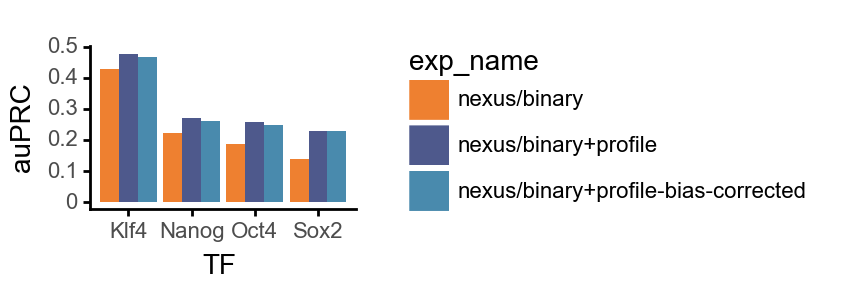

<ggplot: (8743993176745)>

In [81]:
plotnine.options.figure_size = get_figsize(.25)
fig = (ggplot(aes(x='TF', fill='exp_name', y='value'), dfp[dfp.metric_name == 'auPRC']) + 
       geom_bar(stat='identity', position='dodge') + 
       theme_classic(base_size=10, base_family='Arial') +  \
       scale_fill_manual([colors[x] for x in gw_exp]) + \
       ylab("auPRC") 
      )
fig.save(fdir / 'auPRC.binary-vs-profile+binary.with-bias-corrected.bar.v2.pdf')
fig

In [63]:
print(pd.pivot_table(dfp,  values='value', index=['metric_name', 'TF'], columns='exp_name').to_csv())

metric_name,TF,nexus/binary,nexus/binary+profile,nexus/binary+profile-bias-corrected
Recall @ 10% FDR,Klf4,0.000256855680904132,3.3796800118964735e-05,0.02133254023509054
Recall @ 10% FDR,Nanog,0.0,0.0,5.439709882139619e-05
Recall @ 10% FDR,Oct4,0.0010571130676552364,0.0,0.0006950880444856349
Recall @ 10% FDR,Sox2,0.0,0.0,0.000388903292714545
Recall @ 20% FDR,Klf4,0.10018723427265906,0.15059178197008308,0.1572767890336143
Recall @ 20% FDR,Nanog,0.0,0.0,0.0006890299184043518
Recall @ 20% FDR,Oct4,0.007153614457831325,0.030525949953660796,0.005908248378127896
Recall @ 20% FDR,Sox2,0.0,0.0,0.000388903292714545
Recall @ 50% FDR,Klf4,0.41397024529717524,0.47865056136484996,0.4537355603171492
Recall @ 50% FDR,Nanog,0.09031731640979147,0.15513145965548505,0.1300271985494107
Recall @ 50% FDR,Oct4,0.06636642724745134,0.14641740037071363,0.1258978220574606
Recall @ 50% FDR,Sox2,0.04122374902774177,0.14043730014691902,0.13365309826289862
auPRC,Klf4,0.4271689282760627,0.4766495663356172,0.46668673

In [64]:
print(pd.pivot_table(dfp,  values='value', index=['metric_name', 'TF'], columns='exp_name').to_string())

exp_name                nexus/binary  nexus/binary+profile  nexus/binary+profile-bias-corrected
metric_name      TF                                                                            
Recall @ 10% FDR Klf4         0.0003            3.3797e-05                2.1333e-02           
                 Nanog        0.0000            0.0000e+00                5.4397e-05           
                 Oct4         0.0011            0.0000e+00                6.9509e-04           
                 Sox2         0.0000            0.0000e+00                3.8890e-04           
Recall @ 20% FDR Klf4         0.1002            1.5059e-01                1.5728e-01           
                 Nanog        0.0000            0.0000e+00                6.8903e-04           
                 Oct4         0.0072            3.0526e-02                5.9082e-03           
                 Sox2         0.0000            0.0000e+00                3.8890e-04           
Recall @ 50% FDR Klf4         0.4140    

In [65]:
# TODO visualize the matrix
dfp

,TF,exp_name,metric_name,value
0,Oct4,nexus/binary,auPRC,0.1851
1,Oct4,nexus/binary,Recall @ 10% FDR,0.0011
2,Oct4,nexus/binary,Recall @ 20% FDR,0.0072
...,...,...,...,...
57,Klf4,nexus/binary+profile-...,Recall @ 20% FDR,0.1573
58,Klf4,nexus/binary+profile-...,Recall @ 50% FDR,0.4537
59,Klf4,nexus/binary+profile-...,auROC,0.9610


In [66]:
# task = 'Oct4'
# y_true = df_bw_profile[f'{task}/class']
# y_pred = df_bw_profile[f'predicted/{task}/class']
# precision, recall, thresholds = precision_recall_curve(y_true[y_true != -1], y_pred[y_true != -1])

In [67]:
df_list = []
for task in tasks:
    for method, df in zip(['nexus/binary', 'nexus/binary+profile', 'nexus/binary+profile-bias-corrected'],
                          [df_bw, df_bw_profile, df_bw_profile_bias_corrected]):
        y_true = df[f'{task}/class']
        y_pred = df[f'predicted/{task}/class']
        precision, recall, thresholds = precision_recall_curve(y_true[y_true != -1], y_pred[y_true != -1])
        df_list.append(pd.DataFrame({'precision': precision,
                                     'recall': recall,
                                     'method': method,
                                     'TF': task}))

df = df_bw
for task in tasks:
    y_true = df[f'{task}/class']
    y_pred = df[f'predicted/{task}/class'].sample(frac=1)
    precision, recall, thresholds = precision_recall_curve(y_true[y_true != -1], y_pred[y_true != -1])
    df_list.append(pd.DataFrame({'precision': precision,
                             'recall': recall,
                             'method': 'random',
                             'TF': task}))

In [68]:
df_pr = pd.concat(df_list, axis=0)
df_pr['TF'] = pd.Categorical(df_pr['TF'], tasks)

In [73]:
print(df_pr.groupby(['method', 'TF']).size().to_string())

method                               TF   
nexus/binary                         Oct4     6859633
                                     Sox2     6019405
                                     Nanog    7918457
                                     Klf4     7884160
nexus/binary+profile                 Oct4     6948505
                                     Sox2     5956955
                                     Nanog    7970901
                                     Klf4     7861113
nexus/binary+profile-bias-corrected  Oct4     6879128
                                     Sox2     5768594
                                     Nanog    7406967
                                     Klf4     7657729
random                               Oct4     6860355
                                     Sox2     6029538
                                     Nanog    7919753
                                     Klf4     7887028


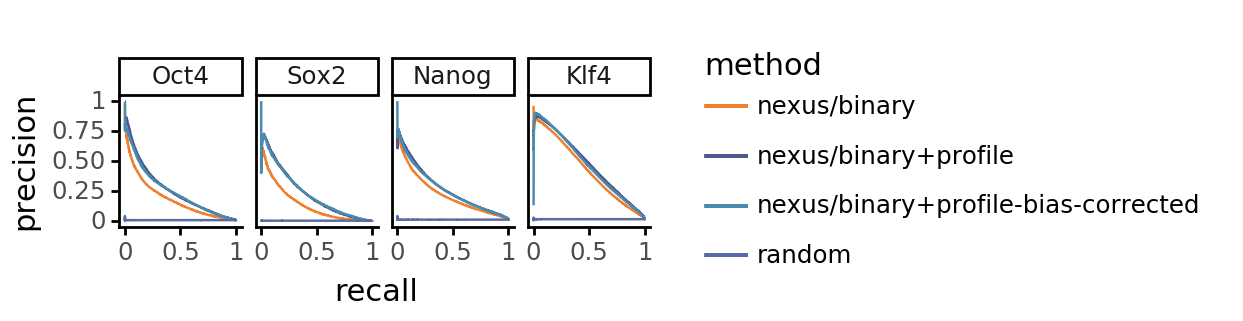

<ggplot: (-9223363291994658367)>

In [80]:
fig = (ggplot(aes(x='recall', y='precision', color='method'),
              data=df_pr.sample(frac=0.1))
  + geom_line()
  + facet_grid('. ~ TF')
  + scale_x_continuous(breaks=[0, .5, 1])
  + theme_classic()
  + theme(figure_size=get_figsize(.5, aspect=0.25))
  + scale_color_manual([colors[x] for x in gw_exp])
)
fig.save(fdir / 'auPRC.binary-vs-profile+binary-vs-bias-corrected.precision-recall.pdf')
fig

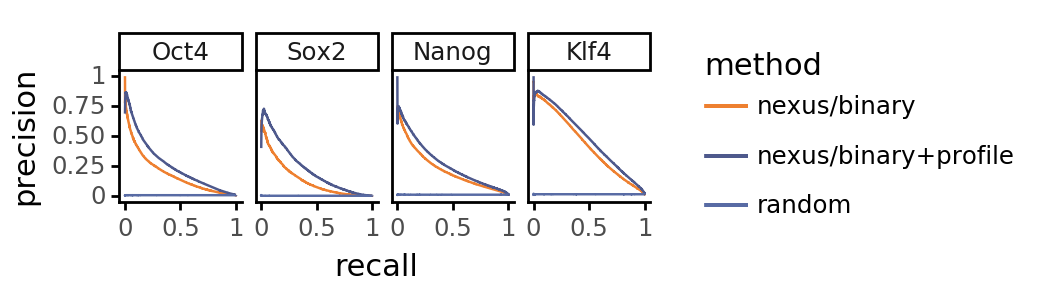

<ggplot: (8736536359993)>

In [67]:
fig = (ggplot(aes(x='recall', y='precision', color='method'),
              data=df_pr.sample(frac=0.1))
  + geom_line()
  + facet_grid('. ~ TF')
  + scale_x_continuous(breaks=[0, .5, 1])
  + theme_classic()
  + theme(figure_size=get_figsize(.5, aspect=0.25))
  + scale_color_manual([colors[x] for x in gw_exp])
)
fig.save(fdir / 'auPRC.binary-vs-profile+binary.precision-recall.pdf')
fig

In [69]:
df_pr.head()

,precision,recall,method,TF
0,0.0069,1.0000,nexus/binary,Oct4
1,0.0071,0.9998,nexus/binary,Oct4
2,0.0071,0.9998,nexus/binary,Oct4
3,0.0071,0.9998,nexus/binary,Oct4
4,0.0071,0.9998,nexus/binary,Oct4


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_true[y_true != -1], y_pred[y_true != -1])

In [76]:
print(df_pr[df_pr.precision >= 0.9].groupby(['method', 'TF']).recall.max().to_string())

method                TF   
nexus/binary          Oct4     1.0713e-03
                      Sox2     0.0000e+00
                      Nanog    0.0000e+00
                      Klf4     2.1543e-04
nexus/binary+profile  Oct4     0.0000e+00
                      Sox2     0.0000e+00
                      Nanog    0.0000e+00
                      Klf4     3.3797e-05
random                Oct4     0.0000e+00
                      Sox2     0.0000e+00
                      Nanog    0.0000e+00
                      Klf4     0.0000e+00


In [77]:
print(df_pr[df_pr.precision >= 0.8].groupby(['method', 'TF']).recall.max().to_string())

method                TF   
nexus/binary          Oct4     0.0075
                      Sox2     0.0000
                      Nanog    0.0000
                      Klf4     0.0973
nexus/binary+profile  Oct4     0.0305
                      Sox2     0.0000
                      Nanog    0.0000
                      Klf4     0.1497
random                Oct4     0.0000
                      Sox2     0.0000
                      Nanog    0.0000
                      Klf4     0.0000


In [78]:
print(df_pr[df_pr.precision >= 0.5].groupby(['method', 'TF']).recall.max().to_string())

method                TF   
nexus/binary          Oct4     0.0667
                      Sox2     0.0421
                      Nanog    0.0902
                      Klf4     0.4106
nexus/binary+profile  Oct4     0.1464
                      Sox2     0.1404
                      Nanog    0.1551
                      Klf4     0.4786
random                Oct4     0.0000
                      Sox2     0.0000
                      Nanog    0.0000
                      Klf4     0.0000


In [79]:
# TODO - formalize these into actual metrics...

In [75]:
# TODO - compute also auROC
# TODO - compile a table of all the metrics

In [68]:
dfp.head()

,TF,exp_name,value
0,Oct4,nexus/binary,0.1846
1,Sox2,nexus/binary,0.1368
2,Nanog,nexus/binary,0.2213
3,Klf4,nexus/binary,0.4251
4,Oct4,nexus/binary+profile,0.2563


In [58]:
# "precision, recall, FP, FN and Venn diagram visualizations for each TF"
# Compute recall@10%,20%FDR and 50%FDR (FDR=1-precision)
# Also report baselind auPR = positives/total bins
# And report auROC as well
# Add a random baseline.


In [ ]:
fig, axes = plt.subplots(1, len(tasks),
                         figsize=get_figsize(.5, aspect=0.4))
for (i, ax), (task, df) in zip(enumerate(axes), df_pr.groupby('TF')):
    for method, dfs in df.sample(frac=0.01).groupby('method'):
        ax.plot(dfs.recall, dfs.precision, label=method)
        if i == 0:
            ax.set_ylabel('Precision')
            ax.set_xlabel('Recall')
        ax.legend()
        ax.set_title(task)
    

In [ ]:
task = 'Oct4'
fig, axes = plt.subplots(1, len(tasks), figsize=get_figsize(.5))
for ax, task in zip(axes, tasks):
    dfsubs
    y_true = df_bw_profile[f'{task}/class']
    y_pred = df_bw_profile[f'predicted/{task}/class']
    precision, recall, thresholds = precision_recall_curve(y_true[y_true != -1], y_pred[y_true != -1])
    ax.plot(recall, precision, label='nexus/binary+profile')

    y_true = df_bw[f'{task}/class']
    y_pred = df_bw[f'predicted/{task}/class']
    precision, recall, thresholds = precision_recall_curve(y_true[y_true != -1], y_pred[y_true != -1])
    ax.plot(recall, precision, label='nexus/binary')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend()

In [71]:
# Compute precision recall curves